In [1]:
import os

os.environ['JAX_ENABLE_X64'] = '1'

import keras
from keras import layers
from keras import ops

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
# Rutas a las carpetas de imágenes y al archivo CSV de anotaciones
path = 'C:\\Users\\saram\\Documents\\TFG\\preprocessed_boats\\'
path_annotations = 'C:\\Users\\saram\\Documents\\TFG\\annotations_v3.xlsx'

In [3]:
# Cargar el archivo CSV con las coordenadas de las cajas
df = pd.read_excel(path_annotations)

df.shape

(81723, 7)

In [4]:
df.head()

,ImageId,ImageWidth,ImageHeight,Xmin,Ymin,Xmax,Ymax
0,000155de5.jpg,768,768,264661,264661,343787,343787
1,000194a2d.jpg,768,768,360486,361252,377390,376621
2,000194a2d.jpg,768,768,51834,51834,64890,64890
3,000194a2d.jpg,768,768,198320,198320,234415,234415
4,000194a2d.jpg,768,768,55683,56451,60291,59523


In [5]:
labels = df['ImageId'].value_counts()

In [6]:
# Filtrar las imágenes que tienen entre 2 barcos y 5 barcos
labels = labels[(labels >= 2) & (labels <= 5)]

(array([7674.,    0.,    0., 2954.,    0.,    0., 1622.,    0.,    0.,
         925.]),
 array([2. , 2.3, 2.6, 2.9, 3.2, 3.5, 3.8, 4.1, 4.4, 4.7, 5. ]),
 <BarContainer object of 10 artists>)

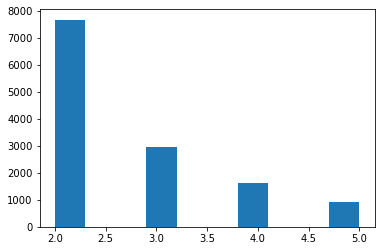

In [7]:
plt.hist(labels)

In [8]:
labels.shape

(13175,)

In [9]:
# convierte a numpy array
y_train = np.array(labels.values)

y_train.shape

(13175,)

In [10]:
images_name = labels.index

In [11]:
# Initialize lists to store filtered images and labels
images = []
# Loop through each ImageId and process the corresponding images
for name in images_name:
    image_path = os.path.join(path, name)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (300, 300))
    images.append(image)

# Convert lists to numpy arrays
x_train = np.array(images)
# Reshape x_train if the images are in grayscale
x_train = np.reshape(x_train, x_train.shape + (1,))

x_train.shape, y_train.shape  

((13175, 300, 300, 1), (13175,))

In [12]:
num_classes = len(labels.unique())

y_train = y_train - 2

In [13]:
# se toma altura y anchura de las imágenes
input_shape = x_train.shape[1:]

num_classes, input_shape

(4, (300, 300, 1))

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((10540, 300, 300, 1), (2635, 300, 300, 1), (10540,), (2635,))

In [15]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 100  
image_size = x_train.shape[1]  
patch_size = 15  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8 # 4-> 8
mlp_head_units = [
    2048,
    1024,
] 

In [16]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        #layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
    
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [17]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [18]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

In [19]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

In [20]:
def create_vit_classifier():
    inputs = keras.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes, activation='softmax')(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 994s 13s/step - accuracy: 0.4223 - loss: 9.2324 - top-5-accuracy: 1.0000 - val_accuracy: 0.5977 - val_loss: 1.1669 - val_top-5-accuracy: 1.0000
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 938s 12s/step - accuracy: 0.5319 - loss: 1.2306 - top-5-accuracy: 1.0000 - val_accuracy: 0.5977 - val_loss: 1.1806 - val_top-5-accuracy: 1.0000
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1104s 15s/step - accuracy: 0.5496 - loss: 1.1864 - top-5-accuracy: 1.0000 - val_accuracy: 0.5977 - val_loss: 1.1225 - val_top-5-accuracy: 1.0000
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 980s 13s/step - accuracy: 0.5445 - loss: 1.1665 - top-5-accuracy: 1.0000 - val_accuracy: 0.5977 - val_loss: 1.1336 - val_top-5-accuracy: 1.0000
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 997s 13s/step - accuracy: 0.5757 - loss: 1.1359 - top-5-accuracy: 1.0000 - val_accuracy: 0.5977 - val_loss: 1.0727 - val_top-5-accuracy: 1.0000
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 955s 13s/step - accuracy: 0.5788 - loss: 1.1278 - 

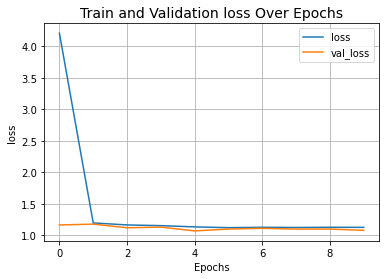

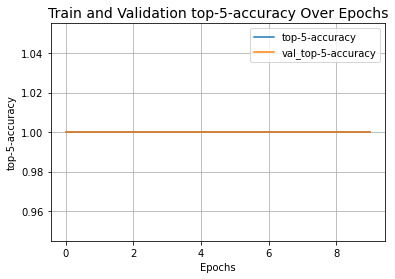

In [21]:
def run_experiment(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.2,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")
plot_history("top-5-accuracy")

In [22]:
pred = vit_classifier.predict(x_test)
y_pred = np.argmax(pred, axis=1)

pd.DataFrame(pred).head()

83/83 ━━━━━━━━━━━━━━━━━━━━ 67s 772ms/step


,0,1,2,3
0,0.411580,0.234503,0.204807,0.149109
1,0.406732,0.257653,0.204283,0.131333
2,0.520696,0.227816,0.161654,0.089834
3,0.376924,0.259191,0.249052,0.114833
4,0.372887,0.240704,0.220803,0.165606


In [23]:
y_pred = y_pred + 1
y_test = y_test + 1

In [24]:
y_test

array([3, 3, 2, ..., 3, 1, 3], dtype=int64)

In [25]:
y_pred

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [26]:
from sklearn.metrics import accuracy_score

In [27]:
accuracy_score(y_test, y_pred)

0.5802656546489564

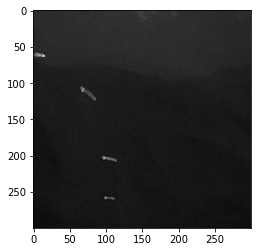

In [28]:
plt.imshow(x_test[0], cmap='gray')

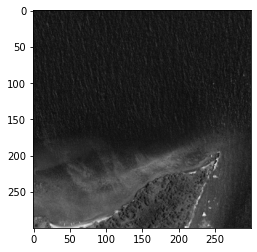

In [29]:
plt.imshow(x_test[1], cmap='gray')

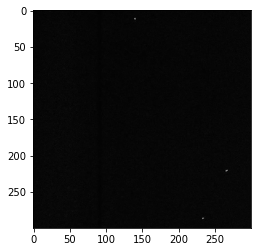

In [30]:
plt.imshow(x_test[2], cmap='gray')

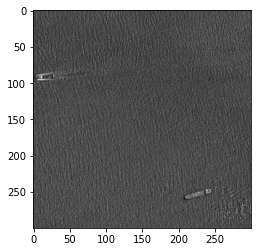

In [31]:
plt.imshow(x_test[3], cmap='gray')

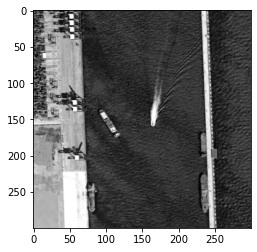

In [32]:
plt.imshow(x_test[4], cmap='gray')